In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import torch
import torch.nn as nn
from torch.autograd import Variable

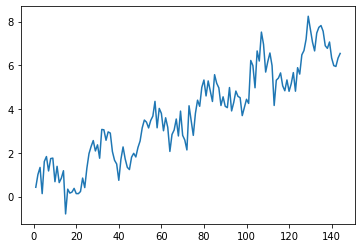

In [7]:
flightData=DataFrame()
flightData["x"]=linspace(1,144,144)
flightData["y"]=flightData["x"]*0.05+sin(flightData["x"]/4.0)+numpy.random.normal(0.0,0.5,(144))
plot(flightData["x"],flightData["y"])

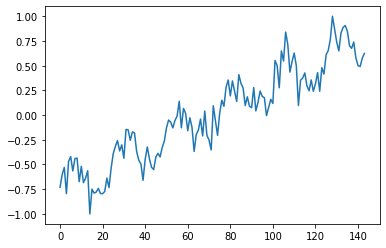

In [10]:
def normalizeAB(a,b,x):
    minX=x.min()
    maxX=x.max()
    return (b-a)*((x-minX)/(maxX-minX))+a

train_data_normalized = normalizeAB(-1.0,1.0,flightData["y"])
plot(train_data_normalized)

In [16]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq.flatten() ,train_label))
    return inout_seq

train_window = 12
train_inout_seq = create_inout_sequences(numpy.array(train_data_normalized), train_window)

In [17]:
train_inout_seq

[(array([-0.7303345 , -0.60164281, -0.52970765, -0.79463957, -0.46998279,
         -0.41954182, -0.56526306, -0.44000707, -0.43532714, -0.67393628,
         -0.5185471 , -0.68310858]), array([-0.63840441])),
 (array([-0.60164281, -0.52970765, -0.79463957, -0.46998279, -0.41954182,
         -0.56526306, -0.44000707, -0.43532714, -0.67393628, -0.5185471 ,
         -0.68310858, -0.63840441]), array([-0.56298894])),
 (array([-0.52970765, -0.79463957, -0.46998279, -0.41954182, -0.56526306,
         -0.44000707, -0.43532714, -0.67393628, -0.5185471 , -0.68310858,
         -0.63840441, -0.56298894]), array([-1.])),
 (array([-0.79463957, -0.46998279, -0.41954182, -0.56526306, -0.44000707,
         -0.43532714, -0.67393628, -0.5185471 , -0.68310858, -0.63840441,
         -0.56298894, -1.        ]), array([-0.7494248])),
 (array([-0.46998279, -0.41954182, -0.56526306, -0.44000707, -0.43532714,
         -0.67393628, -0.5185471 , -0.68310858, -0.63840441, -0.56298894,
         -1.        , -0.7494

In [81]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(RNN,self).__init__()
        self.hidden_layer_size=hidden_layer_size
        nr_of_layers_in_rnn=1
        
        self.rnn=nn.RNN(input_size,self.hidden_layer_size,nr_of_layers_in_rnn,
                        batch_first=True, nonlinearity='tanh')
        self.linear = nn.Linear(hidden_layer_size,output_size)
        
    def forward(self,input_seq):
        h0= torch.zeros(1,1,self.hidden_layer_size)
        rnn_out,h0 = self.rnn(input_seq,h0)
        print("h0",h0.shape)
        out=self.linear(rnn_out)
        return out[0][-1]
    
model=RNN()
print(model)
print(train_inout_seq[0][0],train_inout_seq[0][1])
sequence=torch.Tensor(train_inout_seq[0][0].reshape(1,12,1))
out=model(sequence)
print()
print(sequence.shape,out.shape)

RNN(
  (rnn): RNN(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
[-0.7303345  -0.60164281 -0.52970765 -0.79463957 -0.46998279 -0.41954182
 -0.56526306 -0.44000707 -0.43532714 -0.67393628 -0.5185471  -0.68310858] [-0.63840441]
h0 torch.Size([1, 1, 100])

torch.Size([1, 12, 1]) torch.Size([1])


In [54]:
model = RNN()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        #model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
        #                torch.zeros(1, 1, model.hidden_layer_size))

        #y_pred = model(seq)
        y_pred = model(torch.Tensor(seq.reshape(1,12,1)))

        single_loss = loss_function(y_pred, torch.Tensor(labels))
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00951992
epoch:  26 loss: 0.00558403
epoch:  51 loss: 0.00355005
epoch:  76 loss: 0.00203852
epoch: 101 loss: 0.00264055
epoch: 126 loss: 0.00379186
epoch: 149 loss: 0.0043233922


In [59]:
result=[]
expectation=[]

for i in range(len(train_inout_seq)):
    result.append(model(torch.Tensor(train_inout_seq[i][0].reshape(1,12,1))).detach())
    expectation.append(train_inout_seq[i][1])

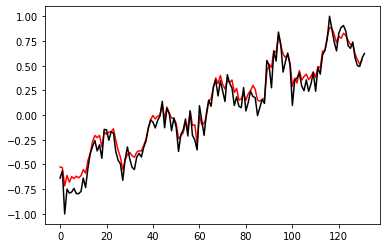

In [63]:
plot(numpy.array(result).flatten()[1:],'r')
plot(numpy.array(expectation).flatten(),'k')

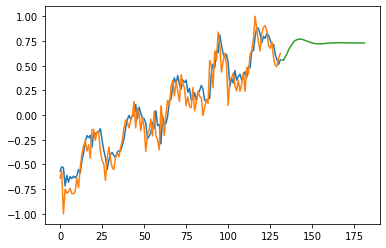

In [67]:
currentSeq=train_inout_seq[-1][0].tolist()
extra=[]
for i in range(50):
    e=model(torch.Tensor(currentSeq).reshape(1,12,1))
    extra.append(e)
    currentSeq.pop(0)
    currentSeq.append(float(e))
    #print(currentSeq)
plot(result)
plot(expectation)
plot(numpy.array(range(50))+132,extra)

In [83]:
class OurLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(OurLSTM,self).__init__()
        self.hidden_layer_size=hidden_layer_size
        nr_of_layers_in_lstm=1
        
        self.lstm=nn.LSTM(input_size,self.hidden_layer_size,nr_of_layers_in_lstm,
                        batch_first=True)
        
        self.linear = nn.Linear(hidden_layer_size,output_size)
        
    def forward(self,input_seq):
        h0= (torch.zeros(1,1,self.hidden_layer_size),
             torch.zeros(1,1,self.hidden_layer_size))
        lstm_out,h0 = self.lstm(input_seq,h0)
        #print("h0",h0[0].shape,h0[1].shape)
        out=self.linear(lstm_out)
        return out[0][-1]
    
model=OurLSTM()
print(model)
print(train_inout_seq[0][0],train_inout_seq[0][1])
sequence=torch.Tensor(train_inout_seq[0][0].reshape(1,12,1))
out=model(sequence)
print()
print(sequence.shape,out.shape)

OurLSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
[-0.7303345  -0.60164281 -0.52970765 -0.79463957 -0.46998279 -0.41954182
 -0.56526306 -0.44000707 -0.43532714 -0.67393628 -0.5185471  -0.68310858] [-0.63840441]

torch.Size([1, 12, 1]) torch.Size([1])


In [84]:
model = OurLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        #model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
        #                torch.zeros(1, 1, model.hidden_layer_size))

        #y_pred = model(seq)
        y_pred = model(torch.Tensor(seq.reshape(1,12,1)))

        single_loss = loss_function(y_pred, torch.Tensor(labels))
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.02868416
epoch:  26 loss: 0.00819231
epoch:  51 loss: 0.00126016
epoch:  76 loss: 0.00895327
epoch: 101 loss: 0.01356819
epoch: 126 loss: 0.00247496
epoch: 149 loss: 0.0015131789


In [85]:
result=[]
expectation=[]

for i in range(len(train_inout_seq)):
    result.append(model(torch.Tensor(train_inout_seq[i][0].reshape(1,12,1))).detach())
    expectation.append(train_inout_seq[i][1])

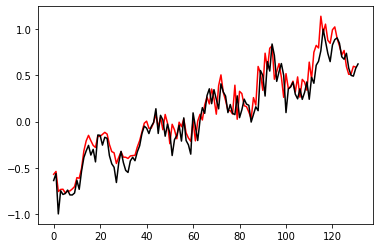

In [88]:
plot(numpy.array(result).flatten(),'r')
plot(numpy.array(expectation).flatten(),'k')

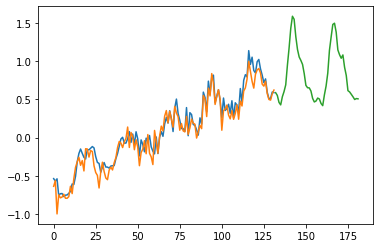

In [89]:
currentSeq=train_inout_seq[-1][0].tolist()
extra=[]
for i in range(50):
    e=model(torch.Tensor(currentSeq).reshape(1,12,1))
    extra.append(e)
    currentSeq.pop(0)
    currentSeq.append(float(e))
    #print(currentSeq)
plot(result)
plot(expectation)
plot(numpy.array(range(50))+132,extra)

In [99]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(RNN,self).__init__()
        self.hidden_layer_size=hidden_layer_size
        nr_of_layers_in_rnn=1
        
        self.rnn=nn.RNN(input_size,self.hidden_layer_size,nr_of_layers_in_rnn,
                        batch_first=True, nonlinearity='tanh')
        self.linear = nn.Linear(hidden_layer_size,output_size)
        
    def forward(self,input_seq):
        batchSize=input_seq.shape[0]
        h0= torch.zeros(1,batchSize,self.hidden_layer_size)
        rnn_out,h0 = self.rnn(input_seq,h0)
        print("h0",h0.shape)
        out=self.linear(rnn_out)
        return out[:, -1, :].squeeze(-1)

rnn=RNN(hidden_layer_size=10)
output=rnn(torch.Tensor(numpy.random.random((10,12,1))))
print(output.shape)

h0 torch.Size([1, 10, 10])
torch.Size([10])
